### A Study in Imputation: Predicting Diabetes from Medical Data with Various Imputation Strategies
***

Here our goal is to build a predictive model for diagnosing diabetes using the <a href="https://www.kaggle.com/mathchi/diabetes-data-set">following diabetes dataset</a> from Kaggle.  We eventually settle on using a random forest classifier to implement our model.

However, before we can do so, we must deal with the fact that this dataset has a large amount of missing data.  This is complicated by the fact that the missing data in this dataset is indicated by zeroes, which in some cases can be interpreted either as a missing value or as a genuine entry.  To circumvent these problems, we implement a number of simple imputation strategies to arrive at a model with predictive accuracy of about 90 percent, as well as discover a few counterintuitive facts about imputation by binning along the way.

Let's import the packages we'll be using.

In [59]:
import pandas as pd
import scipy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error, confusion_matrix

filterwarnings("ignore", category = DeprecationWarning) 
filterwarnings("ignore", category = FutureWarning) 
filterwarnings("ignore", category = UserWarning)

plt.style.use('dark_background')

Next we import our data into a dataframe.  We create a copy to preserve the original data.

In [60]:
data = pd.read_csv('diabetes.csv')
df = data.copy()

Let's explore our dataframe.

In [61]:
display(df.head(15))
display(df.info())
display(df.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We see that, while there are no apparent missing values in the data frame, some entries take on the value zero where it is not physically meaningful.  Therefore it seems that zeroes indicate missing values in this data set.

Let's replace zero values with missing values to get a better idea of how much data is missing.  We also provide a visualization of the missing values in the dataframe.

<AxesSubplot:>

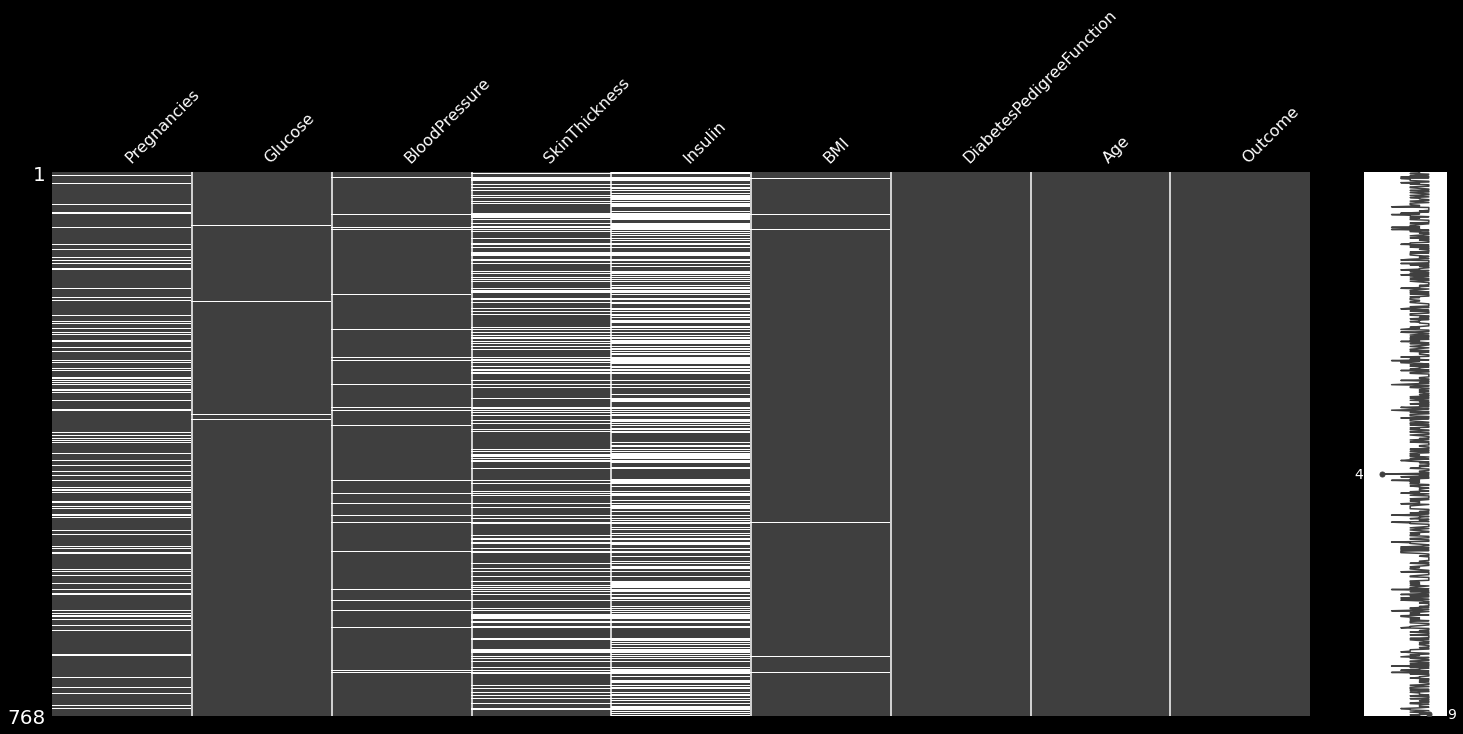

In [62]:
impute_list = ["Glucose", "BloodPressure", "SkinThickness", "BMI",
               "DiabetesPedigreeFunction", "Age", "Insulin", "Pregnancies"]

df[impute_list] = df[impute_list].replace(0, np.NaN)

msno.matrix(df)

We come to our first difficulty.  In most columns a zero is not physically relevant.  However, this is not true of the Pregnancies column, since it is of course possible to have never had a pregnancy.  None of the dataset documentation addresses how to interpret a zero in the Pregnancies column.  For now we will leave the missing values in the Pregnancies column.  But we must remember that artificially imputing those values naively might result in worse predictive performance.

We are now ready to begin building our machine learning model.  We choose to use the random forest classifier with 200 iterations.  Then we split the data randomly into training and testing sets, fit on the training data and score on the testing data 60 times.  This simulates a distribution for the accuracy score, which we then plot and record some summary statistics.

In [63]:
def rfc_predict_score(X, y, n_iter = 60):

# Repeats a train-test split of observations X and outcomes y n_iter times.
# Prodcues a histogram of the sampling distribution of mean accuracy, a confusion matrix,
# as well as the significance and power of the prediction.
# Returns the list of n_iter accuracy scores.

    rfc = RandomForestClassifier(n_estimators = 200,
                                 criterion = 'entropy')
    
    list_for_hist = []
    
    print("[" + ("-" * n_iter) + "]")
    print(" ", end = "")
    
    for i in range(n_iter):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size = 0.2)
        rfc.fit(X_train, y_train)
        score = rfc.score(X_test, y_test)
        print("*", end = "")
        list_for_hist.append(score)
        
    sns.histplot(list_for_hist)
    plt.show()
    
    y_pred = rfc.predict(X_test)
        
    print("Mean Accuracy :", np.mean(list_for_hist))
    print("Standard Error : ", np.std(list_for_hist))
    cm = confusion_matrix(y_test, y_pred)
    print("Significance : ", cm[1][0]/(cm[1][0] + cm[0][0]))
    print("Power : ", cm[1][1]/(cm[1][1] + cm[0][1]))
    
    return list_for_hist

First we will make the ideal hypothesis that the zeroes in the Pregnancies feature were actually intended to be zero values.  We therefore impute the missing values by replacing the missing zeroes in the Pregnancies feature, and imputing the others with the mean, binning by the Outcome.

[------------------------------------------------------------]
 ************************************************************

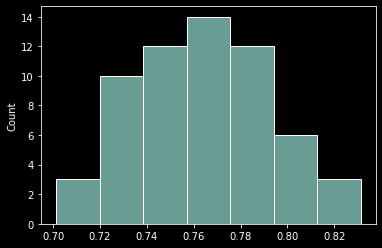

Mean Accuracy : 0.7633116883116883
Standard Error :  0.028586797322645654
Significance :  0.18584070796460178
Power :  0.7317073170731707


In [64]:
impute_features = ["Glucose", "BloodPressure", "SkinThickness", "BMI",
               "DiabetesPedigreeFunction", "Age", "Insulin"]

df_zero = df.copy()

for feature in impute_features:
    df_zero.loc[df['Outcome'] == 0, [feature]] = df_zero.loc[df['Outcome'] == 0, [feature]].fillna(df_zero.loc[df['Outcome'] == 0, :][feature].mean())
    df_zero.loc[df['Outcome'] == 1, [feature]] = df_zero.loc[df['Outcome'] == 1, [feature]].fillna(df_zero.loc[df['Outcome'] == 0, :][feature].mean())

df_zero.loc[:, ['Pregnancies']] = df_zero.loc[:, ['Pregnancies']].fillna(0)

X_zero = df_zero.drop(['Outcome'], axis = 'columns')
y_zero = df_zero['Outcome']

list_zero = rfc_predict_score(X_zero, y_zero)

We observe an accuracy of around 75-76 percent, with a standard error of 2-3 percent.

Next, we suppose that the zeroes in the Pregnancies feature are intended as missing values.  Accordingly we impute by imputing the median on every feature, binning by the Outcome.

[------------------------------------------------------------]
 ************************************************************

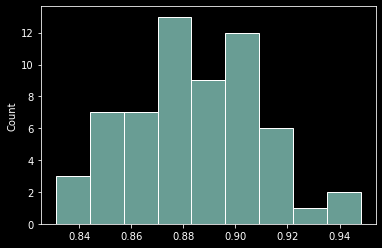

Mean Accuracy : 0.8849567099567098
Standard Error :  0.02252824625387263
Significance :  0.10185185185185185
Power :  0.9130434782608695


In [65]:
impute_features = ["Glucose", "BloodPressure", "SkinThickness", "BMI",
               "DiabetesPedigreeFunction", "Age", "Insulin", "Pregnancies"]

df_mean = df.copy()

for feature in impute_features:
    df_mean.loc[df['Outcome'] == 0, [feature]] = df_mean.loc[df['Outcome'] == 0, [feature]].fillna(df_mean.loc[df['Outcome'] == 0, :][feature].median())
    df_mean.loc[df['Outcome'] == 1, [feature]] = df_mean.loc[df['Outcome'] == 1, [feature]].fillna(df_mean.loc[df['Outcome'] == 1, :][feature].median())
    
X_mean = df_mean.drop(['Outcome'], axis = 'columns')
y_mean = df_mean['Outcome']

list_mean = rfc_predict_score(X_mean, y_mean)

We find a remarkable improvement in accuracy, now between 88-89 percent accuracy with a standard error of 2-3 percent.  This result suggests that the zeroes in the Pregnancies column are indeed intended to be missing values.  However, this is strange, since it would imply that the more than 700 participants in the study comprising our dataset have all been pregnant at least one time.

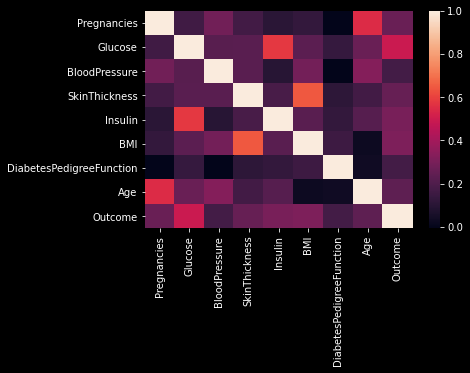

In [66]:
sns.heatmap(df.corr())
plt.show()

We therefore suggest another hypothesis: naively treating our predictor as a linear predictor, we see that all of the features correlate positively with Outcome.  Hence, imputing a large number of entries to equal zero irrespective of outcome introduces a large error in the fit.  This motivates us to impute small values in observations with Outcome 0 and large values in observations with Outcome 1.  Since 'small' and 'large' in this context must be fixed with refence to the dataset, we impute the minimum on missing values in observations of Outcome 0 and maximum values in missing values in observations with Outcome 1.

[------------------------------------------------------------]
 ************************************************************

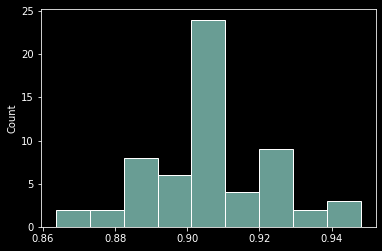

Mean Accuracy : 0.9056277056277057
Standard Error :  0.01744271828390111
Significance :  0.0970873786407767
Power :  0.9215686274509803


In [67]:
impute_features = ["Glucose", "BloodPressure", "SkinThickness", "BMI",
               "DiabetesPedigreeFunction", "Age", "Insulin", "Pregnancies"]

df_minmax = df.copy()

for feature in impute_features:
    df_minmax.loc[df['Outcome'] == 0, [feature]] = df_minmax.loc[df['Outcome'] == 0, [feature]].fillna(df_minmax.loc[df['Outcome'] == 0, :][feature].min())
    df_minmax.loc[df['Outcome'] == 1, [feature]] = df_minmax.loc[df['Outcome'] == 1, [feature]].fillna(df_minmax.loc[df['Outcome'] == 1, :][feature].max())
    
X_minmax = df_minmax.drop(['Outcome'], axis = 'columns')
y_minmax = df_minmax['Outcome']

list_minmax = rfc_predict_score(X_minmax, y_minmax)

We see what appears to be a modest improvement over imputing the median binned by Outcome: we now find an accuracy of 90-91 percent with a standard deviation of 2-3 percent.  To demonstrate that this improvement is significant, we test stochastic inequality with the Mann-Whitney test, so as not to assume anything about the underlying sampling distributions.

In [68]:
u_score, p_value = mannwhitneyu(list_mean, list_minmax)

print("P-Value comparing mean and min-max imputation : ", p_value)

P-Value comparing mean and min-max imputation :  9.324046718207212e-08


**Conclusion**

We examined a dataset intended to allow for prediction of the incidence of diabetes based on auxiliary features.  The data set given contained a large number of missing values, indicated by zeroes in the data set.  Most zero entries were not physically meaningful, and so there was no confusion between a reported zero value and a missing value, except in the case of the Pregnancies feature.

Therefore we investigated whether a ML model would perform better if the zeroes in the Pregnancies feature were left as zeroes or imputed.  We found that there was a significant increase in performance if the zeroes in the Pregnancies column were imputed with the median, from near 75-76 percent accurancy to near 88-89 percent.

Since this result was counterintuitive, we suspected a purely model-based explanation for the phenomenon.  Roughly, since the features are all positively correlated with the target, setting missing values to zero for observations with Outcome 1 greatly increased the fitting error as opposed to simply imputing by averaging.

To determine whether this explanation is plausble, we sought to take advantage of this hypothetical effect by imputing by binning, but set the imputation value to the maximum for observations with Outcome 1, and the minimum for observations with Outcome 0.  Indeed, this choice significantly increased the accuracy of the predictions by another 2 percent, to 90-91 percent accuracy.